In [1]:
import glob
import keras
from keras.callbacks import ModelCheckpoint
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.models import load_model

Using TensorFlow backend.
c:\programdata\miniconda3\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\programdata\miniconda3\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
np.random.seed(1337)
random.seed(1337)

## Read ESC-50 metadata

In [3]:
meta_data = pd.read_csv('./ESC-50-master/meta/esc50.csv')

In [4]:
print(meta_data.shape)
meta_data.head()

(2000, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Visualizing a dog audio sample via melspectrogram

In [5]:
y, sr = librosa.load('./ESC-50-master/audio/1-100032-A-0.wav')
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 216)

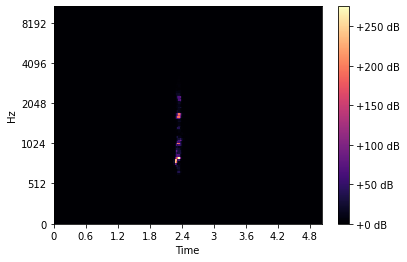

In [6]:
librosa.display.specshow(ps, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

## Split dataset into train, validation, and test

In [7]:
filenames = meta_data['filename']
labels = meta_data['target']

In [8]:
x_train_val, x_test_names, y_train_val, y_test = train_test_split(filenames, labels, random_state=1337, stratify=labels, test_size=.15)
x_train_names, x_val_names, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=1337, stratify=y_train_val, test_size=0.117647058823529)

x_train_names = np.array(x_train_names)
x_val_names = np.array(x_val_names)
x_test_names = np.array(x_test_names)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Load dataset without augmentation

In [9]:
x_train = []
x_val = []
x_test = []

for name in x_train_names:
    y, sr = librosa.load('./ESC-50-master/audio/' + name, duration=4.67)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    assert ps.shape == (128, 202)
    x_train.append(ps)
    
for name in x_val_names:
    y, sr = librosa.load('./ESC-50-master/audio/' + name, duration=4.67)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    assert ps.shape == (128, 202)
    x_val.append(ps)

for name in x_test_names:
    y, sr = librosa.load('./ESC-50-master/audio/' + name, duration=4.67)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    assert ps.shape == (128, 202)
    x_test.append(ps)

In [10]:
x_train_ = np.array([x.reshape( (128, 202, 1) ) for x in x_train])
x_val_ = np.array([x.reshape( (128, 202, 1) ) for x in x_val])
x_test_ = np.array([x.reshape( (128, 202, 1) ) for x in x_test])

y_train_ = np.array(keras.utils.to_categorical(y_train, 50))
y_val_ = np.array(keras.utils.to_categorical(y_val, 50))
y_test_ = np.array(keras.utils.to_categorical(y_test, 50))

## Load in ResNet50 architecture with new weights

In [11]:
model = keras.applications.resnet_v2.ResNet50V2(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
callbacks = [ModelCheckpoint('./models/resnet50v2.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

history1 = model.fit(x_train_,
          y_train_, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=callbacks)

Train on 1500 samples, validate on 200 samples
Epoch 1/20
1500/1500 [==============================] - 50s 33ms/step - loss: 4.0710 - accuracy: 0.0380 - val_loss: 98.7875 - val_accuracy: 0.0250
Epoch 2/20
1500/1500 [==============================] - 31s 21ms/step - loss: 3.5734 - accuracy: 0.0807 - val_loss: 5.8239 - val_accuracy: 0.0600
Epoch 3/20
1500/1500 [==============================] - 31s 21ms/step - loss: 3.2456 - accuracy: 0.1180 - val_loss: 4.4620 - val_accuracy: 0.0400
Epoch 4/20
1500/1500 [==============================] - 31s 21ms/step - loss: 3.0266 - accuracy: 0.1647 - val_loss: 4.8320 - val_accuracy: 0.0650
Epoch 5/20
1500/1500 [==============================] - 31s 21ms/step - loss: 2.6654 - accuracy: 0.2533 - val_loss: 5.7349 - val_accuracy: 0.0950
Epoch 6/20
1500/1500 [==============================] - 31s 21ms/step - loss: 2.3654 - accuracy: 0.3080 - val_loss: 16.0040 - val_accuracy: 0.0600
Epoch 7/20
1500/1500 [==============================] - 31s 21ms/step - los

In [30]:
keras.backend.clear_session()

In [31]:
vgg16model = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [32]:
vgg16model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
vgg16model_callbacks = [ModelCheckpoint('./models/vgg16.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

vgg16model_history = vgg16model.fit(x_train_,
          y_train_, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=vgg16model_callbacks)

Train on 1500 samples, validate on 200 samples
Epoch 1/20
1500/1500 [==============================] - 37s 25ms/step - loss: 6.1536 - accuracy: 0.0153 - val_loss: 3.9120 - val_accuracy: 0.0200
Epoch 2/20
1500/1500 [==============================] - 26s 17ms/step - loss: 3.9171 - accuracy: 0.0233 - val_loss: 3.9121 - val_accuracy: 0.0200
Epoch 3/20
1500/1500 [==============================] - 26s 17ms/step - loss: 3.9419 - accuracy: 0.0160 - val_loss: 3.7772 - val_accuracy: 0.0450
Epoch 4/20
1500/1500 [==============================] - 26s 17ms/step - loss: 3.6929 - accuracy: 0.0567 - val_loss: 3.3900 - val_accuracy: 0.0900
Epoch 5/20
1500/1500 [==============================] - 26s 17ms/step - loss: 3.3320 - accuracy: 0.0900 - val_loss: 3.1971 - val_accuracy: 0.1200
Epoch 6/20
1500/1500 [==============================] - 26s 17ms/step - loss: 3.1486 - accuracy: 0.1153 - val_loss: 3.3120 - val_accuracy: 0.1100
Epoch 7/20
1500/1500 [==============================] - 26s 17ms/step - loss:

In [34]:
keras.backend.clear_session()

In [86]:
mobilenetmodel = keras.applications.mobilenet.MobileNet(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [87]:
mobilenetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
mobilenetmodel_callbacks = [ModelCheckpoint('./models/mobilenet.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

mobilenetmodel_history = mobilenetmodel.fit(x_train_,
          y_train_, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=mobilenetmodel_callbacks)

Train on 1500 samples, validate on 200 samples
Epoch 1/20
1500/1500 [==============================] - 23s 15ms/step - loss: 3.6282 - accuracy: 0.0960 - val_loss: 4.0140 - val_accuracy: 0.0200
Epoch 2/20
1500/1500 [==============================] - 14s 9ms/step - loss: 2.9665 - accuracy: 0.1827 - val_loss: 4.4759 - val_accuracy: 0.0200
Epoch 3/20
1500/1500 [==============================] - 14s 9ms/step - loss: 2.5309 - accuracy: 0.2600 - val_loss: 5.0876 - val_accuracy: 0.0200
Epoch 4/20
1500/1500 [==============================] - 14s 9ms/step - loss: 2.2474 - accuracy: 0.3427 - val_loss: 5.6272 - val_accuracy: 0.0200
Epoch 5/20
1500/1500 [==============================] - 14s 9ms/step - loss: 1.8759 - accuracy: 0.4200 - val_loss: 6.1613 - val_accuracy: 0.0200
Epoch 6/20
1500/1500 [==============================] - 14s 9ms/step - loss: 1.5761 - accuracy: 0.5073 - val_loss: 6.9411 - val_accuracy: 0.0200
Epoch 7/20
1500/1500 [==============================] - 14s 9ms/step - loss: 1.408

In [38]:
keras.backend.clear_session()

In [39]:
densenetmodel = keras.applications.densenet.DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [40]:
densenetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
densenetmodel_callbacks = [ModelCheckpoint('./models/densenet.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

densenetmodel_history = densenetmodel.fit(x_train_,
          y_train_, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=densenetmodel_callbacks)

Train on 1500 samples, validate on 200 samples
Epoch 1/20
1500/1500 [==============================] - 85s 57ms/step - loss: 3.7521 - accuracy: 0.0693 - val_loss: 7.2604 - val_accuracy: 0.0250
Epoch 2/20
1500/1500 [==============================] - 42s 28ms/step - loss: 3.1361 - accuracy: 0.1587 - val_loss: 6.6286 - val_accuracy: 0.0400
Epoch 3/20
1500/1500 [==============================] - 42s 28ms/step - loss: 2.7278 - accuracy: 0.2233 - val_loss: 9.0564 - val_accuracy: 0.0500
Epoch 4/20
1500/1500 [==============================] - 42s 28ms/step - loss: 2.4059 - accuracy: 0.3000 - val_loss: 7.5581 - val_accuracy: 0.0700
Epoch 5/20
1500/1500 [==============================] - 42s 28ms/step - loss: 2.1462 - accuracy: 0.3647 - val_loss: 11.5792 - val_accuracy: 0.0400
Epoch 6/20
1500/1500 [==============================] - 42s 28ms/step - loss: 1.8999 - accuracy: 0.4227 - val_loss: 9.2781 - val_accuracy: 0.0450
Epoch 7/20
1500/1500 [==============================] - 42s 28ms/step - loss

In [42]:
keras.backend.clear_session()

## Load in augmented data

In [102]:
x_train_aug = []
y_train_aug = []

for name in glob.glob('./ESC-50-master/augmented_audio/*'):
    y, sr = librosa.load(name, duration=4.67)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    assert ps.shape == (128, 202)
    x_train_aug.append(ps)
    y_train_aug.append(int(name[32:34]))

In [103]:
x_train_aug_ = np.array([x.reshape( (128, 202, 1) ) for x in x_train_aug])
y_train_aug_ = np.array(keras.utils.to_categorical(y_train_aug, 50))

x_train_all = np.concatenate((x_train_, x_train_aug_), axis=0)
y_train_all = np.concatenate((y_train_, y_train_aug_), axis=0)

## Train on augmented training data

In [62]:
model2 = keras.applications.resnet_v2.ResNet50V2(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [63]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
callbacks2 = [ModelCheckpoint('./models/resnet50v2aug-dn.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

history2 = model2.fit(x_train_all,
          y_train_all, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=callbacks2)

Train on 4500 samples, validate on 200 samples
Epoch 1/20
4500/4500 [==============================] - 105s 23ms/step - loss: 3.6167 - accuracy: 0.0838 - val_loss: 4.0843 - val_accuracy: 0.0650
Epoch 2/20
4500/4500 [==============================] - 91s 20ms/step - loss: 2.7641 - accuracy: 0.2191 - val_loss: 7.9894 - val_accuracy: 0.0550
Epoch 3/20
4500/4500 [==============================] - 91s 20ms/step - loss: 2.1061 - accuracy: 0.3818 - val_loss: 6.5006 - val_accuracy: 0.0900
Epoch 4/20
4500/4500 [==============================] - 91s 20ms/step - loss: 1.6293 - accuracy: 0.5122 - val_loss: 15.9970 - val_accuracy: 0.0750
Epoch 5/20
4500/4500 [==============================] - 91s 20ms/step - loss: 1.2828 - accuracy: 0.6151 - val_loss: 13.8068 - val_accuracy: 0.0550
Epoch 6/20
4500/4500 [==============================] - 91s 20ms/step - loss: 0.9666 - accuracy: 0.7011 - val_loss: 9.9212 - val_accuracy: 0.0850
Epoch 7/20
4500/4500 [==============================] - 91s 20ms/step - lo

In [65]:
keras.backend.clear_session()

In [81]:
vgg16modelaug = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [82]:
vgg16modelaug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
vgg16modelaug_callbacks = [ModelCheckpoint('./models/vgg16aug.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

vgg16modelaug_history = vgg16modelaug.fit(x_train_all,
          y_train_all, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=vgg16modelaug_callbacks)

Train on 13500 samples, validate on 200 samples
Epoch 1/20
13500/13500 [==============================] - 233s 17ms/step - loss: 3.8393 - accuracy: 0.0541 - val_loss: 3.0061 - val_accuracy: 0.1600
Epoch 2/20
13500/13500 [==============================] - 228s 17ms/step - loss: 2.4923 - accuracy: 0.2611 - val_loss: 2.5461 - val_accuracy: 0.3200
Epoch 3/20
13500/13500 [==============================] - 228s 17ms/step - loss: 1.5409 - accuracy: 0.5114 - val_loss: 2.5559 - val_accuracy: 0.3900
Epoch 4/20
13500/13500 [==============================] - 228s 17ms/step - loss: 0.7935 - accuracy: 0.7409 - val_loss: 3.2445 - val_accuracy: 0.4050
Epoch 5/20
13500/13500 [==============================] - 228s 17ms/step - loss: 0.4046 - accuracy: 0.8668 - val_loss: 4.3076 - val_accuracy: 0.3850
Epoch 6/20
13500/13500 [==============================] - 227s 17ms/step - loss: 0.2582 - accuracy: 0.9190 - val_loss: 3.8487 - val_accuracy: 0.3850
Epoch 7/20
13500/13500 [==============================] - 

In [89]:
keras.backend.clear_session()

In [104]:
mobilenetmodelaug = keras.applications.mobilenet.MobileNet(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [105]:
mobilenetmodelaug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
mobilenetmodelaug_callbacks = [ModelCheckpoint('./models/mobilenetaug-ps.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

mobilenetmodelaug_history = mobilenetmodelaug.fit(x_train_all,
          y_train_all, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=mobilenetmodelaug_callbacks)

Train on 7500 samples, validate on 200 samples
Epoch 1/20
7500/7500 [==============================] - 76s 10ms/step - loss: 2.6349 - accuracy: 0.2673 - val_loss: 6.0313 - val_accuracy: 0.0200
Epoch 2/20
7500/7500 [==============================] - 69s 9ms/step - loss: 1.3525 - accuracy: 0.5856 - val_loss: 7.8780 - val_accuracy: 0.0200
Epoch 3/20
7500/7500 [==============================] - 69s 9ms/step - loss: 0.7871 - accuracy: 0.7512 - val_loss: 8.9965 - val_accuracy: 0.0550
Epoch 4/20
7500/7500 [==============================] - 69s 9ms/step - loss: 0.4455 - accuracy: 0.8592 - val_loss: 7.5670 - val_accuracy: 0.1200
Epoch 5/20
7500/7500 [==============================] - 69s 9ms/step - loss: 0.2697 - accuracy: 0.9165 - val_loss: 8.7141 - val_accuracy: 0.1050
Epoch 6/20
7500/7500 [==============================] - 69s 9ms/step - loss: 0.2022 - accuracy: 0.9403 - val_loss: 9.1520 - val_accuracy: 0.1200
Epoch 7/20
7500/7500 [==============================] - 69s 9ms/step - loss: 0.138

In [73]:
keras.backend.clear_session()

In [74]:
densenetmodelaug = keras.applications.densenet.DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(128,202,1), pooling=None, classes=50)

In [75]:
densenetmodelaug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
densenetmodelaug_callbacks = [ModelCheckpoint('./models/densenetaug-dn.h5', monitor='val_loss', verbose=0, 
                    save_best_only=True, save_weights_only=False, mode='auto', period=1)]

densenetmodelaug_history = densenetmodelaug.fit(x_train_all,
          y_train_all, 
          epochs=20, 
          verbose=1,
          batch_size=32,
          validation_data=(x_val_, y_val_),
          callbacks=densenetmodelaug_callbacks)

Train on 4500 samples, validate on 200 samples
Epoch 1/20
4500/4500 [==============================] - 158s 35ms/step - loss: 3.2843 - accuracy: 0.1424 - val_loss: 3.7746 - val_accuracy: 0.0950
Epoch 2/20
4500/4500 [==============================] - 123s 27ms/step - loss: 2.2470 - accuracy: 0.3418 - val_loss: 6.1724 - val_accuracy: 0.0600
Epoch 3/20
4500/4500 [==============================] - 123s 27ms/step - loss: 1.6659 - accuracy: 0.4929 - val_loss: 7.6404 - val_accuracy: 0.0650
Epoch 4/20
4500/4500 [==============================] - 123s 27ms/step - loss: 1.2642 - accuracy: 0.6102 - val_loss: 8.9706 - val_accuracy: 0.0650
Epoch 5/20
4500/4500 [==============================] - 123s 27ms/step - loss: 0.9067 - accuracy: 0.7209 - val_loss: 8.5315 - val_accuracy: 0.0750
Epoch 6/20
4500/4500 [==============================] - 123s 27ms/step - loss: 0.7054 - accuracy: 0.7836 - val_loss: 6.9971 - val_accuracy: 0.1200
Epoch 7/20
4500/4500 [==============================] - 123s 27ms/step 

In [77]:
keras.backend.clear_session()

## Test models on test set

In [ ]:
model.evaluate(x_test_, y_test_)

In [ ]:
model2.evaluate(x_test_, y_test_)

In [31]:
def print_metrics(predictions, groun_truth):
    average_type = 'macro'

    accuracy = accuracy_score(predictions, groun_truth)
    precision = precision_score(predictions, groun_truth, average=average_type)
    recall = recall_score(predictions, groun_truth, average=average_type)
    f1 = f1_score(predictions, groun_truth, average=average_type)
    
    print('acc: ', accuracy)
    print('pre: ', precision)
    print('rec: ', recall)
    print('f1 : ', f1)

In [94]:
model_names = ['mobilenet.h5', 'resnet50v2.h5', 'vgg16.h5']

for name in model_names:
    print(name)
    
    loaded_model = load_model('./models/' + name)
    predictions = loaded_model.predict(x_test_, verbose=0)
    loaded_model_predictions = []
    
    for prediction in predictions:
        loaded_model_predictions.append(np.argmax(prediction))
    
    print_metrics(loaded_model_predictions, y_test)

mobilenet.h5
acc:  0.02
pre:  0.02
rec:  0.0004
f1 :  0.000784313725490196
resnet50v2.h5
acc:  0.06
pre:  0.06
rec:  0.024224117906203692
f1 :  0.02497138459223767
vgg16.h5
acc:  0.33666666666666667
pre:  0.33666666666666667
rec:  0.37220202020202015
f1 :  0.3257581103273703


In [ ]:
model_names = ['densenetaug.h5', 'mobilenetaug.h5', 'resnet50v2aug.h5', 'vgg16aug.h5']

for name in model_names:
    print(name)
    
    loaded_model = load_model('./models/' + name)
    predictions = loaded_model.predict(x_test_, verbose=0)
    loaded_model_predictions = []
    
    for prediction in predictions:
        loaded_model_predictions.append(np.argmax(prediction))
    
    print_metrics(loaded_model_predictions, y_test)

In [107]:
model_names = ['densenetaug-ps.h5', 'mobilenetaug-ps.h5', 'resnet50v2aug-ps.h5', 'vgg16aug-ps.h5']

for name in model_names:
    print(name)
    
    loaded_model = load_model('./models/' + name)
    predictions = loaded_model.predict(x_test_, verbose=0)
    loaded_model_predictions = []
    
    for prediction in predictions:
        loaded_model_predictions.append(np.argmax(prediction))
    
    print_metrics(loaded_model_predictions, y_test)

densenetaug-ps.h5
acc:  0.07333333333333333
pre:  0.07333333333333333
rec:  0.06016859195468821
f1 :  0.050130142414854896
mobilenetaug-ps.h5
acc:  0.02
pre:  0.02
rec:  0.0004
f1 :  0.000784313725490196
resnet50v2aug-ps.h5
acc:  0.07
pre:  0.07
rec:  0.03659095526243234
f1 :  0.028946076903971645
vgg16aug-ps.h5
acc:  0.4
pre:  0.4
rec:  0.43108080808080806
f1 :  0.3832570109628934


In [101]:
model_names = ['densenetaug-ts.h5', 'mobilenetaug-ts.h5', 'resnet50v2aug-ts.h5', 'vgg16aug-ts.h5']

for name in model_names:
    print(name)
    
    loaded_model = load_model('./models/' + name)
    predictions = loaded_model.predict(x_test_, verbose=0)
    loaded_model_predictions = []
    
    for prediction in predictions:
        loaded_model_predictions.append(np.argmax(prediction))
    
    print_metrics(loaded_model_predictions, y_test)

densenetaug-ts.h5
acc:  0.11333333333333333
pre:  0.11333333333333333
rec:  0.1045859553123575
f1 :  0.08372826908541194
mobilenetaug-ts.h5
acc:  0.02
pre:  0.02
rec:  0.0004
f1 :  0.000784313725490196
resnet50v2aug-ts.h5
acc:  0.12666666666666668
pre:  0.12666666666666665
rec:  0.07068743265479437
f1 :  0.06786451076727877
vgg16aug-ts.h5
acc:  0.3933333333333333
pre:  0.3933333333333333
rec:  0.40639789295671647
f1 :  0.36680673613639014


In [95]:
model_names = ['mobilenetaug-dn.h5', 'resnet50v2aug-dn.h5', 'vgg16aug-dn.h5']

for name in model_names:
    print(name)
    
    loaded_model = load_model('./models/' + name)
    predictions = loaded_model.predict(x_test_, verbose=0)
    loaded_model_predictions = []
    
    for prediction in predictions:
        loaded_model_predictions.append(np.argmax(prediction))
    
    print_metrics(loaded_model_predictions, y_test)

mobilenetaug-dn.h5
acc:  0.55
pre:  0.55
rec:  0.6231434676434676
f1 :  0.5467541230699126
resnet50v2aug-dn.h5


KeyboardInterrupt: 